In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import math as math
from scipy.stats import boxcox
from random import randrange
from random import seed
from random import random
from random import gauss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Multiply, Concatenate, Dropout
from pyod.models.knn import KNN 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score,roc_curve,auc

In [2]:
data=pd.read_csv("synthetic_weather_data_wo_label_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)
data_labeled=pd.read_csv("synthetic_weather_data_wi_label_supervised_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)

In [3]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 1096   # 3 year
train= data.iloc[:-Ntest].copy()
test= data.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = data.index <=train.index[-1]
test_idx = data.index > train.index[-1]

data.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
data.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

data.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
data.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

data.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
data.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

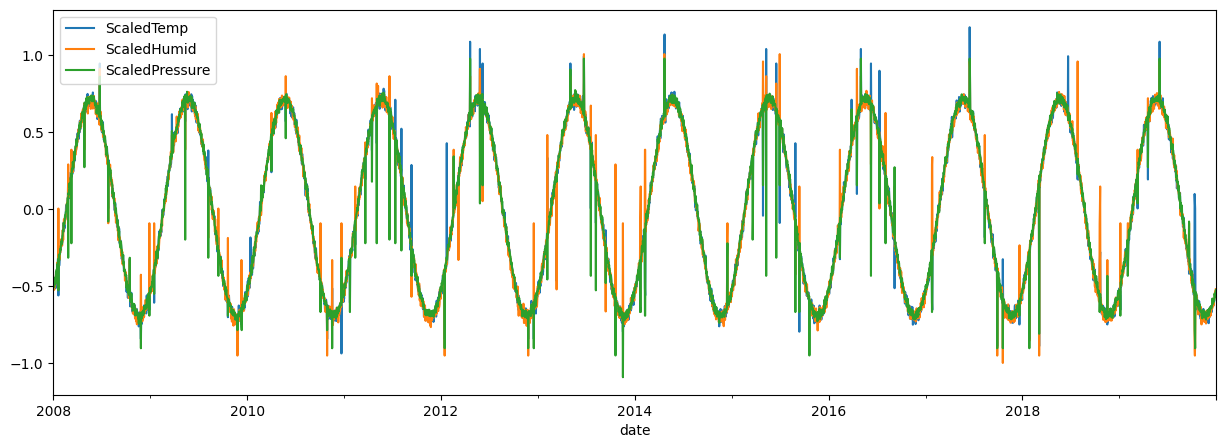

In [4]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

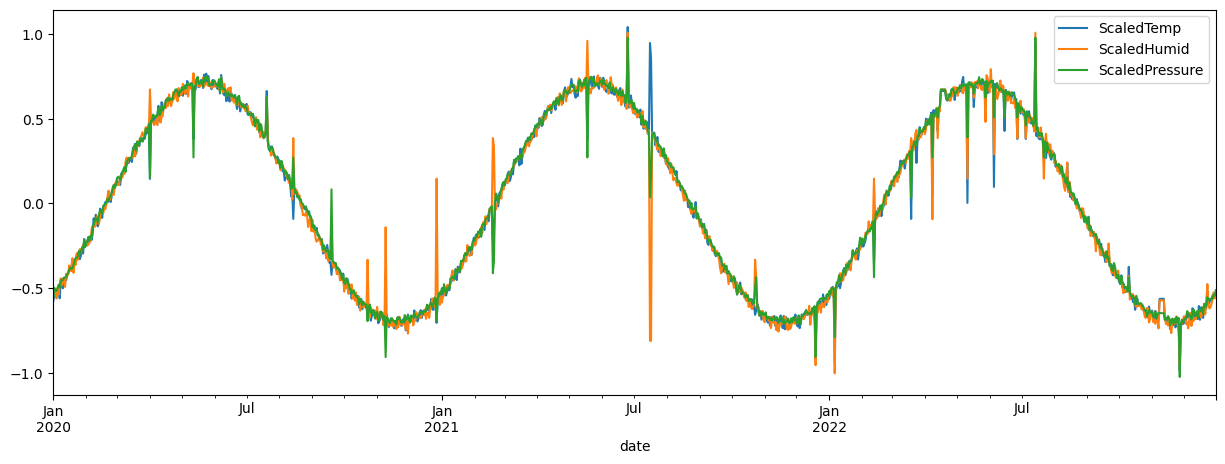

In [5]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

In [6]:
df_combined=[train[cols],test[cols]]
df_combined=pd.concat(df_combined, axis=0)

### Physical Modeling with VAR when 3 year test set and 50 lag

In [7]:
lag_order = 50

In [8]:
"""temp_pred= 0.15*temp(t-1)+0.04*temp(t-2)+0.03*humid(t-2)+0.03*humid(t-5)+0.05*temp(t-6)+0.03*humid(t-9)+0.03*temp(t-10)
              +0.03*humid(t-12)+0.05*pressure(t-13)+0.03*humid(t-15)+0.03*pressure(t-15)+0.03*pressure(t-18)+0.03*humid(t-21)
              -0.03*pressure(t-32)+0.05*temp(t-37)-0.03*pressure(t-38)-0.05*temp(t-49)-0.03*temp(t-50)-0.03*pressure(t-50)"""

'temp_pred= 0.15*temp(t-1)+0.04*temp(t-2)+0.03*humid(t-2)+0.03*humid(t-5)+0.05*temp(t-6)+0.03*humid(t-9)+0.03*temp(t-10)\n              +0.03*humid(t-12)+0.05*pressure(t-13)+0.03*humid(t-15)+0.03*pressure(t-15)+0.03*pressure(t-18)+0.03*humid(t-21)\n              -0.03*pressure(t-32)+0.05*temp(t-37)-0.03*pressure(t-38)-0.05*temp(t-49)-0.03*temp(t-50)-0.03*pressure(t-50)'

In [9]:
"""humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)
            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)"""

'humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)\n            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)'

In [10]:
"""pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)
                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)
                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)"""

'pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)\n                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)\n                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)'

In [11]:
df_laggedtemp=pd.DataFrame()
df_laggedtemp['temp_L1']=df_combined['ScaledTemp'].shift(1)
df_laggedtemp['temp_L2']=df_combined['ScaledTemp'].shift(2)
df_laggedtemp['humid_L2']=df_combined['ScaledHumid'].shift(2)
df_laggedtemp['humid_L5']=df_combined['ScaledHumid'].shift(5)
df_laggedtemp['temp_L6']=df_combined['ScaledTemp'].shift(6)
df_laggedtemp['humid_L9']=df_combined['ScaledHumid'].shift(9)
df_laggedtemp['temp_L10']=df_combined['ScaledTemp'].shift(10)
df_laggedtemp['humid_L12']=df_combined['ScaledHumid'].shift(12)
df_laggedtemp['pressure_L13']=df_combined['ScaledPressure'].shift(13)
df_laggedtemp['humid_L15']=df_combined['ScaledHumid'].shift(15)
df_laggedtemp['pressure_L15']=df_combined['ScaledPressure'].shift(15)
df_laggedtemp['pressure_L18']=df_combined['ScaledPressure'].shift(18)
df_laggedtemp['humid_L21']=df_combined['ScaledHumid'].shift(21)
df_laggedtemp['pressure_L32']=df_combined['ScaledPressure'].shift(32)
df_laggedtemp['temp_L37']=df_combined['ScaledTemp'].shift(37)
df_laggedtemp['pressure_L38']=df_combined['ScaledPressure'].shift(38)
df_laggedtemp['temp_L49']=df_combined['ScaledTemp'].shift(49)
df_laggedtemp['temp_L50']=df_combined['ScaledTemp'].shift(50)
df_laggedtemp['pressure_L50']=df_combined['ScaledPressure'].shift(50)

In [12]:
df_vartemp=[df_laggedtemp['temp_L1'],df_laggedtemp['temp_L2'],df_laggedtemp['humid_L2'],df_laggedtemp['humid_L5'],
            df_laggedtemp['temp_L6'],df_laggedtemp['humid_L9'],df_laggedtemp['temp_L10'],
            df_laggedtemp['humid_L12'],df_laggedtemp['pressure_L13'],
            df_laggedtemp['humid_L15'],df_laggedtemp['pressure_L15'],
            df_laggedtemp['pressure_L18'],df_laggedtemp['humid_L21'],
            df_laggedtemp['pressure_L32'],df_laggedtemp['temp_L37'],
            df_laggedtemp['pressure_L38'],df_laggedtemp['temp_L49'],
            df_laggedtemp['temp_L50'],df_laggedtemp['pressure_L50']]
df_vartemp=pd.concat(df_vartemp,axis=1)

### Humidity prediction from VAR Model

In [13]:
"""humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)
            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)"""

'humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)\n            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)'

In [14]:
df_laggedhumid=pd.DataFrame()
df_laggedhumid['humid_L1']=df_combined['ScaledHumid'].shift(1)
df_laggedhumid['pressure_L3']=df_combined['ScaledPressure'].shift(3)
df_laggedhumid['pressure_L10']=df_combined['ScaledPressure'].shift(10)
df_laggedhumid['humid_L11']=df_combined['ScaledHumid'].shift(11)
df_laggedhumid['temp_L28']=df_combined['ScaledTemp'].shift(28)
df_laggedhumid['humid_L28']=df_combined['ScaledHumid'].shift(28)
df_laggedhumid['temp_L32']=df_combined['ScaledTemp'].shift(32)
df_laggedhumid['pressure_L37']=df_combined['ScaledPressure'].shift(37)
df_laggedhumid['humid_L47']=df_combined['ScaledHumid'].shift(47)
df_laggedhumid['pressure_L48']=df_combined['ScaledPressure'].shift(48)

In [15]:
df_varhumid=[df_laggedhumid['humid_L1'],df_laggedhumid['pressure_L3'],df_laggedhumid['pressure_L10'],
             df_laggedhumid['humid_L11'],df_laggedhumid['temp_L28'],df_laggedhumid['humid_L28'],df_laggedhumid['temp_L32'],
             df_laggedhumid['pressure_L37'],df_laggedhumid['humid_L47'],
             df_laggedhumid['pressure_L48']]
df_varhumid=pd.concat(df_varhumid,axis=1)

### Pressure prediction from VAR Model

In [16]:
"""pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)
                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)
                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)"""

'pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)\n                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)\n                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)'

In [17]:
df_laggedpressure=pd.DataFrame()
df_laggedpressure['pressure_L1']=df_combined['ScaledPressure'].shift(1)
df_laggedpressure['temp_L12']=df_combined['ScaledTemp'].shift(12)
df_laggedpressure['pressure_L12']=df_combined['ScaledPressure'].shift(12)
df_laggedpressure['temp_L19']=df_combined['ScaledTemp'].shift(19)
df_laggedpressure['temp_L38']=df_combined['ScaledTemp'].shift(38)
df_laggedpressure['humid_L38']=df_combined['ScaledHumid'].shift(38)
df_laggedpressure['humid_L50']=df_combined['ScaledHumid'].shift(50)

In [18]:
df_varpressure=[df_laggedpressure['pressure_L1'],
                        df_laggedpressure['temp_L12'],
                        df_laggedpressure['pressure_L12'],
                        df_laggedpressure['temp_L19'],
                        df_laggedpressure['temp_L38'],df_laggedpressure['humid_L38'],
                        df_laggedpressure['humid_L50']]
df_varpressure=pd.concat(df_varpressure,axis=1)

In [19]:
df=[df_vartemp,df_varhumid,df_varpressure,df_combined]
df=pd.concat(df, axis=1)

In [20]:
df.dropna(inplace=True)

In [21]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 3 year
train_data = df.iloc[:-nest_samples].copy()
test_data = df.iloc[-nest_samples:].copy()

In [22]:
#HERE

In [23]:
features = [col for col in df.columns if col not in ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]
X_train, y_train = train_data[features], train_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']] #Split into X and Y. training data.

In [24]:
x_test, y_test = test_data[features], test_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [25]:
X_train.shape

(4333, 36)

In [26]:
input_tensor = Input(shape=(36,))
hidden1 = Dense(64, activation='relu')(input_tensor)
hidden1_reg = Dropout(0.1)(hidden1)
hidden2 = Dense(96, activation='relu')(hidden1_reg)
hidden2_reg = Dropout(0.1)(hidden2)
hidden3 = Dense(36, activation='relu')(hidden2_reg)
coeffs_temp = Dense(36)(hidden3)
coeffs_humid = Dense(36)(hidden3)
coeffs_pressure = Dense(36)(hidden3)
mul_temp = Multiply()([coeffs_temp, input_tensor])
mul_humidity = Multiply()([coeffs_humid, input_tensor])
mul_pressure = Multiply()([coeffs_pressure, input_tensor])
temp = tf.reduce_sum(mul_temp, axis= -1, keepdims=True)
humid = tf.reduce_sum(mul_humidity, axis= -1, keepdims=True)
pressure =tf.reduce_sum(mul_pressure, axis= -1, keepdims=True)
output=Concatenate(axis=1)([temp, humid, pressure])
model = Model(input_tensor, output)

In [27]:
#optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer='adam')

In [28]:
checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model_3yrTestdata.h5',
    monitor='val_loss',
    save_best_only= True,
    save_weights_only= True,
    mode= 'min'
)

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.0001, mode ="min" ,restore_best_weights=True)
#history = model.fit(X_train.values, y_train.values, epochs=100, batch_size=16, verbose=1, validation_split=0.1, callbacks=[callback,checkpoint])

In [30]:
model.load_weights('best_model_3yrTestdata.h5')

In [31]:
prediction = model.predict(x_test.values)

35/35 [==============================] - 1s 2ms/step


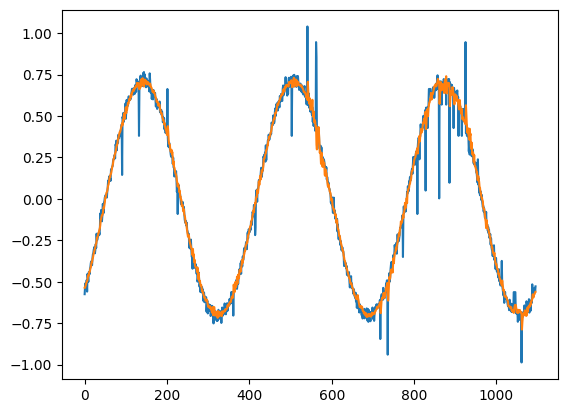

In [32]:
import matplotlib.pyplot as plt
plt.plot(y_test.values[:,0])
plt.plot(prediction[:,0])

In [33]:
Ntest=1096
le=LabelEncoder()

y = data_labeled.iloc[:, -1].values
ground_truth_train = y[:-Ntest].copy()
ground_truth_test = y[-Ntest:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

### Data preparation for kNN

In [34]:
#test_data
data_temp_test = pd.DataFrame({'predicted_temp': prediction[:,0], 'actual_temp': y_test.values[:,0]})
data_humidity_test = pd.DataFrame({'predicted_humid': prediction[:,1], 'actual_humid': y_test.values[:,1]})
data_pressure_test = pd.DataFrame({'predicted_pressure': prediction[:,2], 'actual_pressure': y_test.values[:,2]})
data_kNN_test=pd.concat([data_temp_test,data_humidity_test,data_pressure_test],axis=1)

In [35]:
# Use PyOD's KNN model for anomaly detection
knn_model = KNN()
knn_model.fit(data_kNN_test)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [36]:
prediction_scores = knn_model.decision_function(data_kNN_test)
prediction_labels = knn_model.predict(data_kNN_test)  # raw outlier scores. The higher, the more abnormal.

### Evaluation

In [37]:
unique, counts = np.unique(prediction_labels, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_test), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (prediction_labels != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, prediction_labels, squared=False)
mae = mean_absolute_error(ground_truth_test, prediction_labels)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)


Outlier prediction information on Test Data: 1096 {0: 1001, 1: 95}
No of Errors in test set: 61

RMS on Test Set : 0.2359172191820032

MAE on Test Set : 0.055656934306569344


### Confusion Matrix

In [38]:
#Confusion Matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, knn_model.predict(data_kNN_test))

array([[994,  54],
       [  7,  41]], dtype=int64)

### AUC-ROC

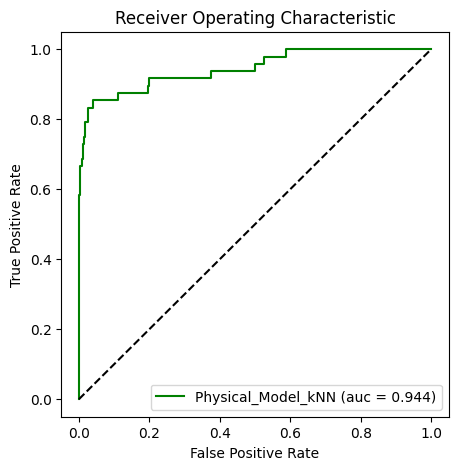

In [39]:
# Calculate AUC-ROC score
auc_roc_pm = roc_auc_score(ground_truth_test, prediction_scores)
fpr_pm, tpr_pm, thresholds_pm = roc_curve(ground_truth_test, prediction_scores)
auc_kNN_pm = auc(fpr_pm,tpr_pm)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_pm, tpr_pm, linestyle='-', color='g', label='Physical_Model_kNN (auc = %0.3f)' % auc_kNN_pm)

plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()